### Link Colab to Google Drive

In [0]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
ls

IHBAS_DataSheet.csv  input/  output/  PM2-5_Predict_LSTM.ipynb


In [0]:
import os
#os.chdir("drive/My Drive/Adil_Work/")
os.listdir()

['input', 'output', 'PM2-5_Predict_LSTM.ipynb', 'IHBAS_DataSheet.csv']

# Steps:

* Importing dependencies & Declaring methods and variables
* Reading and analyzing data. (Pandas)
* Normalizing the data. (SkLearn)
* Converting data to time-series and supervised learning problem.
* Creating model (Keras)

## Importing dependencies & Declaring methods and variables

In [6]:
import numpy as np
import os
import sys
import time
import pandas as pd 
from matplotlib import pyplot as plt
from tqdm._tqdm_notebook import tqdm_notebook
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
params = {
    "batch_size": 10,
    "epochs": 100,
    "lr": 0.0001,
    "time_steps": 60   #length of input, or No of days when concidering Stock prices
}

#project_path = os.getcwd()
#INPUT_PATH = "input/"
#OUTPUT_PATH = "output/"
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]

In [3]:
# trims the dataset so that the entire DS is in multiples of batch size(20 is this case)
# some left out rows from DS are discarded after this.

def trim_dataset(mat,batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat


def build_timeseries(mat, y_col_index):
    """
    Converts ndarray into timeseries format and supervised data format. Takes first TIME_STEPS
    number of rows as input and sets the TIME_STEPS+1th data as corresponding output and so on.
    :param mat: ndarray which holds the dataset
    :param y_col_index: index of column which acts as output
    :return: returns two ndarrays-- input and output in format suitable to feed
    to LSTM.
    """
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    return x, y

In [1]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()


## Reading and analyzing data. (Pandas)

Dataset size:  (687, 13)
Columns:  Index(['SO2', 'Toluene', 'CO', 'NO', 'NO2', 'Nox', 'RH', 'Temp', 'SR', 'VWS',
       'WD', 'WS', 'PM 2.5'],
      dtype='object')


,SO2,Toluene,CO,NO,NO2,Nox,RH,Temp,SR,VWS,WD,WS,PM 2.5
0,18.17,0.49,0.43,3.57,9.05,8.30,49.82,32.93,610.44,-0.97,308.13,0.94,152.50
1,6.60,9.07,0.60,17.16,48.10,37.81,43.94,34.74,191.60,0.43,115.60,0.56,148.50
2,9.55,5.27,0.43,4.35,19.64,14.36,51.17,33.49,228.78,0.51,238.44,0.54,153.22
3,5.68,69.24,0.41,6.80,13.86,13.35,54.94,35.63,416.21,0.49,283.05,0.31,112.35
4,7.60,10.76,0.43,6.95,19.61,17.70,93.27,27.77,395.29,0.32,166.38,0.43,318.57


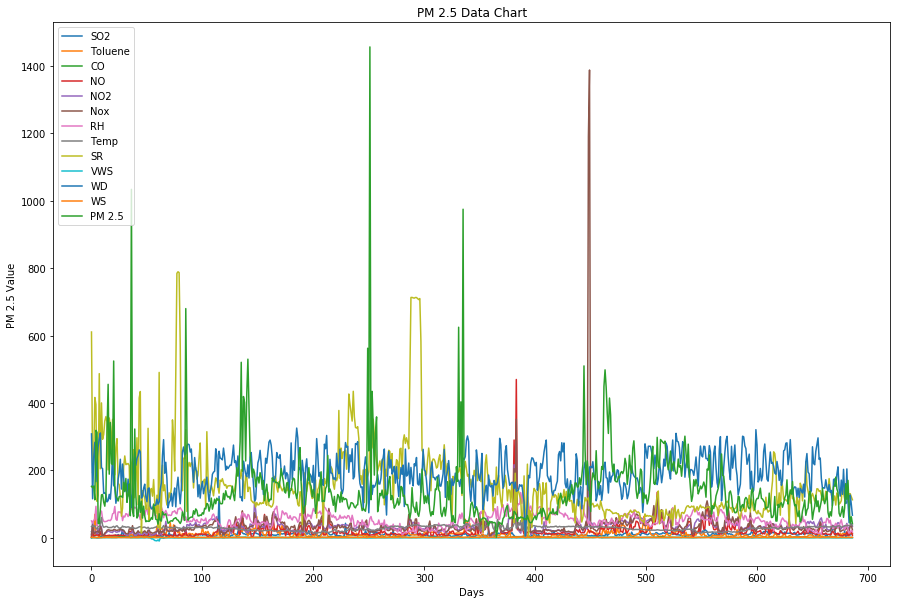

In [4]:
df_ge = pd.read_csv(r"Dwarka2YearData.csv")
print("Dataset size: ", df_ge.shape)
print("Columns: ", df_ge.columns)
display(df_ge.head(5))


plt.figure(figsize=(15,10))
plt.plot(df_ge["SO2"])
plt.plot(df_ge["Toluene"])
plt.plot(df_ge["CO"])
plt.plot(df_ge["NO"])
plt.plot(df_ge["NO2"])
plt.plot(df_ge["Nox"])
plt.plot(df_ge["RH"])
plt.plot(df_ge["Temp"])
plt.plot(df_ge["SR"])
plt.plot(df_ge["VWS"])
plt.plot(df_ge["WD"])
plt.plot(df_ge["WS"])
plt.plot(df_ge["PM 2.5"])
plt.title('PM 2.5 Data Chart')
plt.ylabel('PM 2.5 Value')
plt.xlabel('Days')
plt.legend(['SO2', 'Toluene', 'CO', 'NO', 'NO2', 'Nox', 'RH', 'Temp', 'SR', 'VWS',
       'WD', 'WS', 'PM 2.5'], loc='upper left')
plt.show()

## Normalizing the data. (SkLearn)
The data is not normalized and the range for each column varies, especially Volume. Normalizing data helps the algorithm in converging i.e. to find local/ global minimum efficiently. 

In [8]:
df_train, df_test = train_test_split(df_ge, train_size=0.85, test_size=0.15, shuffle=False)
print("Train--Test size", len(df_train), len(df_test))

# scale the feature MinMax, build array
train_cols = ["SO2", "Toluene", "CO", "NO", "NO2", "Nox", "RH", "Temp", "SR", "VWS",
       "WD", "WS", "PM 2.5"]  # training feautres
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()

x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

#print("Deleting unused dataframes of total size(KB)",(sys.getsizeof(df_ge)+sys.getsizeof(df_train)+sys.getsizeof(df_test))//1024)
#del df_ge, df_test, df_train, x

#print("Are any NaNs present in train/test matrices?",np.isnan(x_train).any(), np.isnan(x_train).any())

Train--Test size 583 104


## Converting data to time-series and supervised learning problem.

LSTMs consume input in format [ batch_size, time_steps, Features ] as a 3- dimensional array.

* Batch Size says how many samples of input do you want your Neural Net to see before updating the weights. So let’s say you have 100 samples (input dataset) and you want to update weights every time your NN has seen an input. In that case batch size would be 1 and total number of batches would be 100. Like wise if you wanted your network to update weights after it has seen all the samples, batch size would be 100 and number of batches would be 1. As it turns out using very small batch size reduces the speed of training and on the other hand using too big batch size (like whole dataset) reduces the models ability to generalize to different data and it also consumes more memory. But it takes fewer steps to find the minima for your objective function. So you have to try out various values on your data and find the sweet spot. It’s quite a big topic.
* Time Steps define how many units back in time you want your network to see. For example if you were working on a character prediction problem where you have a text corpus to train on and you decide to feed your network 6 characters at a time. Then your time step is 6. In our case we will be using 60 as time step i.e. we will look into 2 months of data to predict next day's price.
* Features is the number of attributes used to represent each time step. Consider the character prediction example above, and assume that you use a one-hot encoded vector of size 100 to represent each character. Then feature size here is 100. In our case we will use 5 as the number of attributes.

In [9]:
# 3rd col (Close value ) is the target for this dataset

x_t, y_t = build_timeseries(x_train, 12)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
print("Train size",x_t.shape, y_t.shape)

x_temp, y_temp = build_timeseries(x_test, 12)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

print("Test size", x_test_t.shape, y_test_t.shape)
print("Val size", x_val.shape, y_val.shape)


Train size (520, 60, 13) (520,)



Test size (20, 60, 13) (20,)
Val size (20, 60, 13) (20,)


## Creating model (Keras)

In [10]:
x_t.shape

(520, 60, 13)

In [13]:
def create_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(200, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(LSTM(200, dropout=0.0))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(128,activation='relu'))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(1,activation='sigmoid'))
    optimizer = optimizers.RMSprop(lr=params["lr"])
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    return lstm_model

In [12]:
#Load a model if already created and dumped in a pickle file

model = None
try:
    model = pickle.load(open("lstm_model", 'rb'))
    print("Loaded saved model...")
except FileNotFoundError:
    print("Model not found")

Model not found


### Model Training

In [14]:
is_update_model = True
if model is None or is_update_model:
    print("Building model...")
    
    model = create_model()
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.0001)
    
    mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,
                          "best_model.h5"), monitor='val_loss', verbose=1,
                          save_best_only=True, save_weights_only=False, mode='min', period=1)
    
    csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'training_log_' + time.ctime().replace(" ","_") + '.log'), append=True)
    
    history = model.fit(x_t, y_t, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp, csv_logger])
    
    print("saving model...")
    pickle.dump(model, open(os.path.join(OUTPUT_PATH, "lstm_model"), "wb"))

Building model...


NameError: name 'OUTPUT_PATH' is not defined

### Model Evaluation

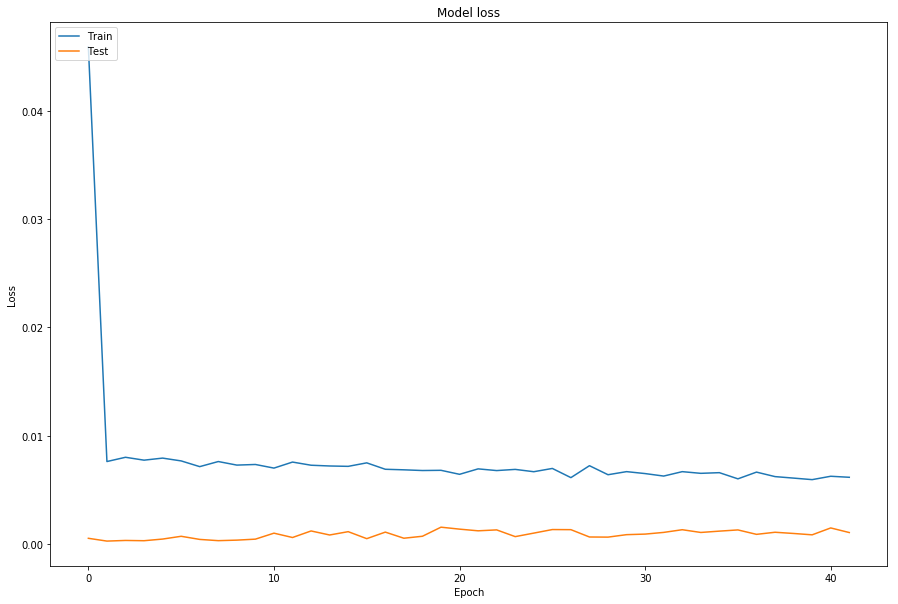

In [0]:
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'train_vs_val_'+str(BATCH_SIZE)+'.png'))

### Model Testing

In [0]:
# load the saved best model from above
saved_model = load_model(os.path.join(OUTPUT_PATH, 'best_model.h5'))
print(saved_model)

y_pred = saved_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)

Error is 0.0007867226071587065 (20,) (20,)


[ 99.583336  99.637184  99.73518   99.83421   99.990616 100.15287
 100.423096 100.627625 100.812515 101.130005  98.28283   98.328186
  98.436455  98.5772    98.76985 ]
[137.22  75.25  60.    77.    64.5  100.   150.5  154.5  179.8  145.2
 134.5   72.8   63.5   75.4   92.5 ]


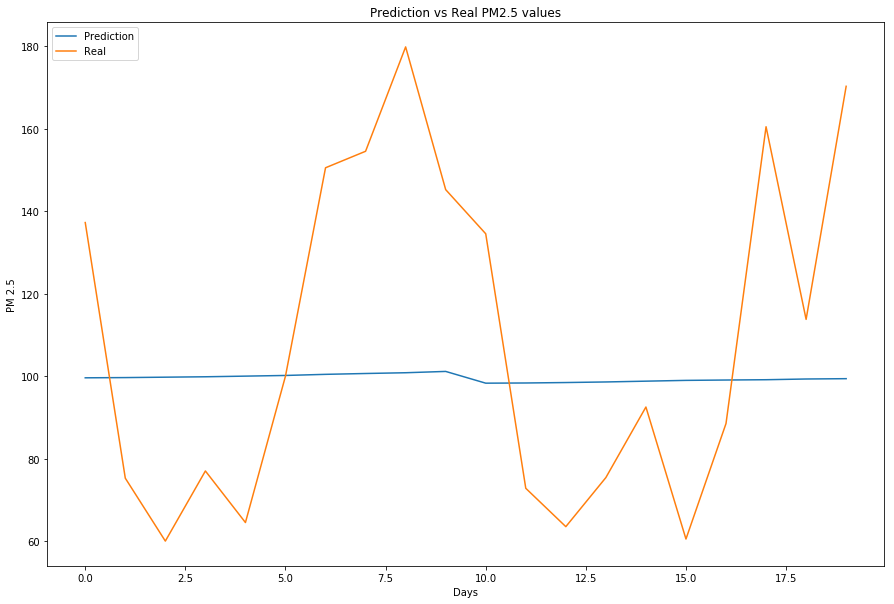

In [0]:
y_pred_org = (y_pred * min_max_scaler.data_range_[12]) + min_max_scaler.data_min_[12] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[12]) + min_max_scaler.data_min_[12] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

plt.figure(figsize=(15,10))
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real PM2.5 values')
plt.ylabel('PM 2.5')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
#plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_PM25'+str(BATCH_SIZE)+'.png'))


# Do It Yourself

But how do you land on the perfect (or in almost all the cases, close to perfect) architecture for your neural network? How do you decide the values for each of the hyper-parameters? Refer to the following link for additional information: [**How to Find the Right Architecture for Neural Network and Fine Tune Hyperparameters**](https://towardsdatascience.com/finding-the-right-architecture-for-neural-network-b0439efa4587)